In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
sys.path.insert(1, str(Path.cwd().parent))
str(Path.cwd().parent)

'c:\\Users\\Joaquín Amat\\Documents\\GitHub\\skforecast'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# set theme for matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDiff import ForecasterAutoregDiff
from sklearn.linear_model import LinearRegression   
from sklearn.ensemble import RandomForestRegressor
from lineartree import LinearForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from skforecast.preprocessing import TimeSeriesDifferentiator

Train dates : 1991-07-01 00:00:00 --- 2003-03-01 00:00:00  (n=141)
Test dates  : 2003-04-01 00:00:00 --- 2008-06-01 00:00:00  (n=63)


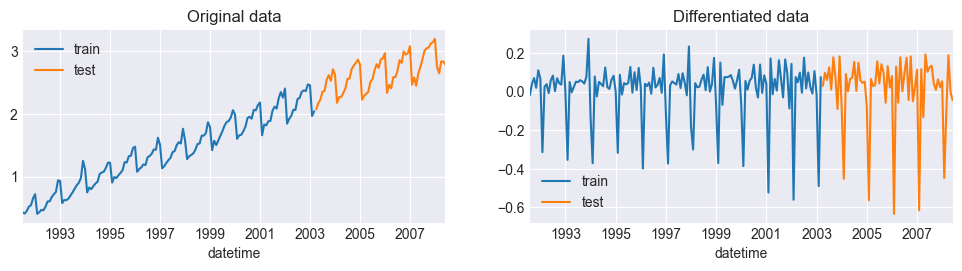

In [3]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
    'data/h2o.csv'
)
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Add a smooth positive trend
# ==============================================================================
t = np.arange(len(data))
data = data + 0.01 * t

# Data differentiated
# ==============================================================================
diferenciator = TimeSeriesDifferentiator(order=1)
data_diff = diferenciator.fit_transform(data)
data_diff = pd.Series(data_diff, index=data.index).dropna()

# Data partition train-test
# ==============================================================================
end_train = '2003-03-01 23:59:00'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, axs = plt.subplots(1, 2, figsize=(12, 2.5))
axs = axs.ravel()
data.loc[:end_train].plot(ax=axs[0], label='train')
data.loc[end_train:].plot(ax=axs[0], label='test')
axs[0].legend()
axs[0].set_title('Original data')

data_diff.loc[:end_train].plot(ax=axs[1], label='train')
data_diff.loc[end_train:].plot(ax=axs[1], label='test')
axs[1].legend()
axs[1].set_title('Differentiated data');

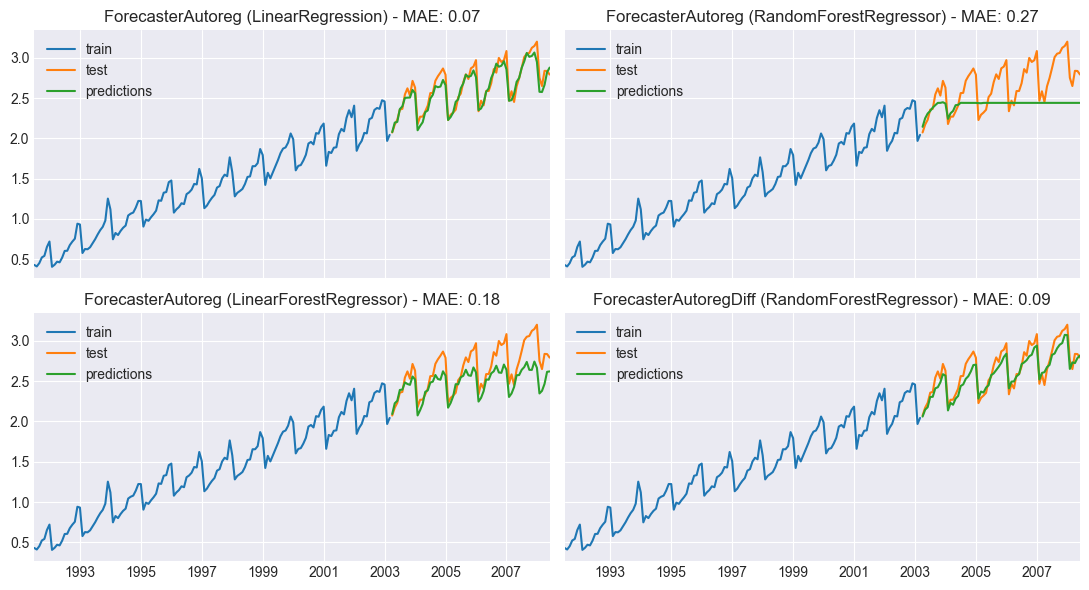

In [4]:
# Compare predictions of different models
# ==============================================================================
regressors = [
    LinearRegression(),
    RandomForestRegressor(random_state=123),
    LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt')
]
steps = len(data.loc[end_train:])

fig, ax = plt.subplots(2, 2, figsize=(11, 6), sharex=True, sharey=True)
ax = ax.ravel()
# ForecasterAutoreg
for i, regressor in enumerate(regressors):
    forecaster = ForecasterAutoreg(
        regressor=regressor,
        lags=15
    )
    forecaster.fit(y=data.loc[:end_train])
    predictions = forecaster.predict(steps=steps)
    error = mean_absolute_error(data.loc[end_train:], predictions)
    data.loc[:end_train].plot(ax=ax[i], label='train')
    data.loc[end_train:].plot(ax=ax[i], label='test')
    predictions.plot(ax=ax[i], label='predictions')
    ax[i].set_title(
        f'ForecasterAutoreg ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=12
    )
    ax[i].set_xlabel('')
    ax[i].legend()

# ForecasterAutoregDiff with random forest
forecaster = ForecasterAutoregDiff(
                 regressor       = RandomForestRegressor(random_state=963),
                 lags            = 15,
                 differentiation = 1
            )
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=steps)
error = mean_absolute_error(data.loc[end_train:], predictions)
data.loc[:end_train].plot(ax=ax[3], label='train')
data.loc[end_train:].plot(ax=ax[3], label='test')
predictions.plot(ax=ax[3], label='predictions')
ax[3].set_title(
        f'ForecasterAutoregDiff ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=12
    )
ax[3].set_xlabel('')
ax[3].legend()

fig.tight_layout()

Series differentiated before training
-------------------------------------
Last window of training series: datetime
2002-01-01    0.143554
2002-02-01   -0.560283
2002-03-01    0.075580
2002-04-01    0.048697
2002-05-01    0.098076
2002-06-01   -0.005842
2002-07-01    0.175968
2002-08-01    0.016304
2002-09-01    0.098830
2002-10-01    0.023778
2002-11-01   -0.010180
2002-12-01    0.105980
2003-01-01   -0.014631
2003-02-01   -0.489849
2003-03-01    0.075037
Freq: MS, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-11-01,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253,-0.018889
1992-12-01,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253
1993-01-01,0.186034,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384


Predictions


2003-04-01    0.017092
2003-05-01    0.085509
2003-06-01    0.030617
2003-07-01    0.127380
2003-08-01    0.001914
                ...   
2008-02-01   -0.419348
2008-03-01    0.081277
2008-04-01   -0.008556
2008-05-01    0.062505
2008-06-01    0.032060
Freq: MS, Name: pred, Length: 63, dtype: float64

2003-04-01    2.060425
2003-05-01    2.145934
2003-06-01    2.176551
2003-07-01    2.303930
2003-08-01    2.305844
                ...   
2008-02-01    2.651466
2008-03-01    2.732743
2008-04-01    2.724187
2008-05-01    2.786692
2008-06-01    2.818752
Length: 63, dtype: float64


Series differentiated during training
-------------------------------------
Last window of training series: datetime
2001-12-01    2.262313
2002-01-01    2.405868
2002-02-01    1.845584
2002-03-01    1.921165
2002-04-01    1.969862
2002-05-01    2.067938
2002-06-01    2.062096
2002-07-01    2.238064
2002-08-01    2.254368
2002-09-01    2.353198
2002-10-01    2.376976
2002-11-01    2.366796
2002-12-01    2.472776
2003-01-01    2.458145
2003-02-01    1.968296
2003-03-01    2.043333
Freq: MS, Name: y, dtype: float64
Train matrix


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-11-01,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253,-0.018889
1992-12-01,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384,0.041253
1993-01-01,0.186034,0.036617,0.043845,0.069298,0.002075,0.082855,0.058733,-0.008007,0.038460,0.025128,-0.313899,0.067467,0.110283,0.019826,0.070384


Predictions


2003-04-01    2.060425
2003-05-01    2.145934
2003-06-01    2.176551
2003-07-01    2.303930
2003-08-01    2.305844
                ...   
2008-02-01    2.651466
2008-03-01    2.732743
2008-04-01    2.724187
2008-05-01    2.786692
2008-06-01    2.818752
Freq: MS, Name: pred, Length: 63, dtype: float64

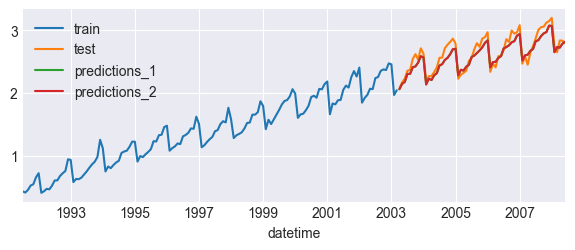

In [5]:
# Comparasion of results if the time series is differenciated before training or during the training
# =================================================================================================
print("Series differentiated before training")
print("-------------------------------------")
forecaster_1 = ForecasterAutoregDiff(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )

forecaster_1.fit(y=data_diff.loc[:end_train])
last_window_1 = forecaster_1.last_window
print(f"Last window of training series: {last_window_1}")
print("Train matrix")
X_train_1, y_train_1 = forecaster_1.create_train_X_y(data_diff.loc[:end_train])
display(X_train_1.head(3))
predictions_diff = forecaster_1.predict(steps=steps)
last_value_train = data.loc[:end_train].iloc[[-1]]
predictions_1 = pd.concat([last_value_train, predictions_diff]).cumsum()[1:]
print("Predictions")
display(predictions_diff)
display(predictions_1)
print("")

print("Series differentiated during training")
print("-------------------------------------")
forecaster_2 = ForecasterAutoregDiff(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 1
             )

forecaster_2.fit(y=data.loc[:end_train])
last_window_2 = forecaster_2.last_window
print(f"Last window of training series: {last_window_2}")
print("Train matrix")
X_train_2, y_train_2 = forecaster_2.create_train_X_y(data.loc[:end_train])
display(X_train_2.head(3))
predictions_2 = forecaster_2.predict(steps=steps)
print("Predictions")
display(predictions_2)

fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_1.plot(ax=ax, label='predictions_1')
predictions_2.plot(ax=ax, label='predictions_2')
ax.legend();


In [6]:
pd.testing.assert_frame_equal(X_train_1, X_train_2, check_names=True)
pd.testing.assert_frame_equal(forecaster_1.get_feature_importances(), forecaster_2.get_feature_importances(), check_names=True)
pd.testing.assert_series_equal(predictions_1.asfreq('MS'), predictions_2, check_names=False)

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

Results do not match for order =2

</div>

In [7]:
diferenciator = TimeSeriesDifferentiator(order=2)
data_diff = diferenciator.fit_transform(data)
data_diff = pd.Series(data_diff, index=data.index).dropna()

In [8]:
forecaster_1 = ForecasterAutoregDiff(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )
X_train_1, y_train_1 = forecaster_1.create_train_X_y(data_diff.loc[:end_train])
display(X_train_1.head(3))

forecaster_2 = ForecasterAutoregDiff(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 2
             )
X_train_2, y_train_2 = forecaster_2.create_train_X_y(data.loc[:end_train])
display(X_train_2.head(3))



,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-12-01,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131,0.060142
1993-01-01,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131
1993-02-01,-0.195789,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558


,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1992-12-01,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131,0.060142
1993-01-01,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558,0.029131
1993-02-01,-0.195789,0.149417,-0.007228,-0.025453,0.067223,-0.080780,0.024122,0.066740,-0.046467,0.013332,0.339027,-0.381366,-0.042816,0.090457,-0.050558


Train dates : 1949-01-01 00:00:00 --- 1956-01-01 00:00:00  (n=85)
Test dates  : 1956-01-01 00:00:00 --- 1960-12-01 00:00:00  (n=60)


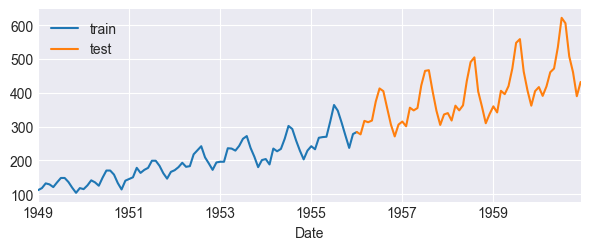

In [9]:
# Download data
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/AirPassengers.csv'
)
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m')
data = data.set_index('Date')
data = data.asfreq('MS')
data = data['Passengers']
data = data.sort_index()


# # Data partition train-test
# # ==============================================================================
end_train = '1956-01-01'
print(
    f"Train dates : {data.index.min()} --- {data.loc[:end_train].index.max()}  " 
    f"(n={len(data.loc[:end_train])})")
print(
    f"Test dates  : {data.loc[end_train:].index.min()} --- {data.index.max()}  "
    f"(n={len(data.loc[end_train:])})")

# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
ax.legend();

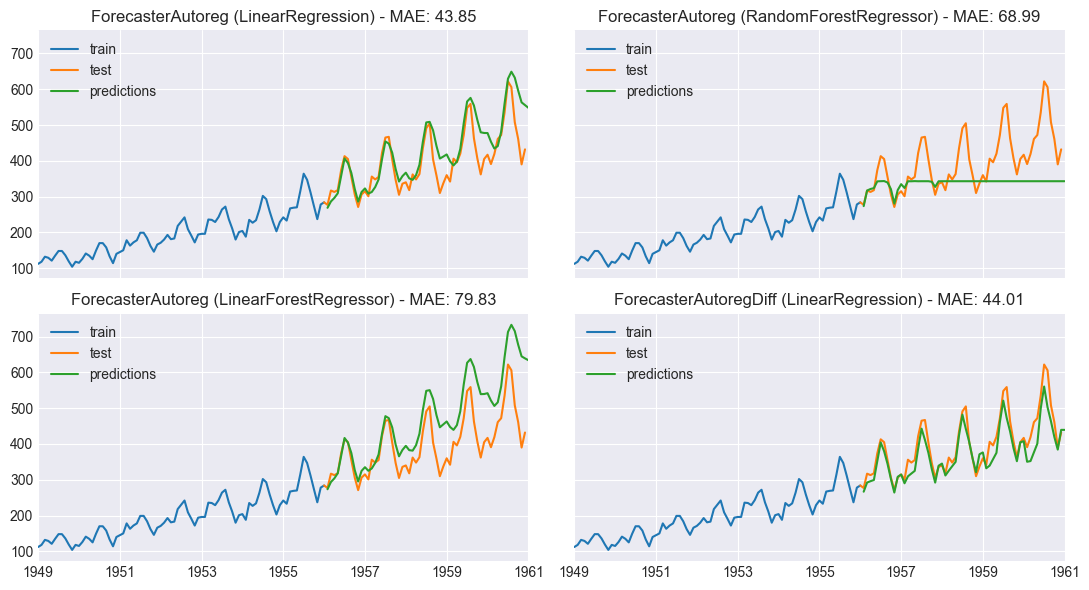

In [10]:
# Compare predictions of different models
# ==============================================================================
regressors = [
    LinearRegression(),
    RandomForestRegressor(random_state=123),
    LinearForestRegressor(base_estimator=LinearRegression(), max_features='sqrt')
]

fig, ax = plt.subplots(2, 2, figsize=(11, 6), sharex=True, sharey=True)
ax = ax.ravel()

# ForecasterAutoreg
for i, regressor in enumerate(regressors):
    forecaster = ForecasterAutoreg(
        regressor=regressor,
        lags=12
    )
    forecaster.fit(y=data.loc[:end_train])
    predictions = forecaster.predict(steps=len(data.loc[end_train:]))
    error = mean_absolute_error(data.loc[end_train:], predictions)
    data.loc[:end_train].plot(ax=ax[i], label='train')
    data.loc[end_train:].plot(ax=ax[i], label='test')
    predictions.plot(ax=ax[i], label='predictions')
    ax[i].set_title(
        f'ForecasterAutoreg ({regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=12
    )
    ax[i].set_xlabel('')
    ax[i].legend()

# ForecasterAutoregDiff with random forest
forecaster = ForecasterAutoregDiff(
                 regressor       = LinearRegression(),
                 lags            = 12,
                 differentiation = 1
            )
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=len(data.loc[end_train:]))
error = mean_absolute_error(data.loc[end_train:], predictions)
data.loc[:end_train].plot(ax=ax[3], label='train')
data.loc[end_train:].plot(ax=ax[3], label='test')
predictions.plot(ax=ax[3], label='predictions')
ax[3].set_title(
        f'ForecasterAutoregDiff ({forecaster.regressor.__class__.__name__}) - MAE: {error:.2f}',
        size=12
    )
ax[3].set_xlabel('')
ax[3].legend()

fig.tight_layout()

c:\anaconda\envs\skforecast_09_py11\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


1956-02-01    271.574028
1956-03-01    294.911618
1956-04-01    298.129025
1956-05-01    301.076074
Freq: MS, Name: predicted_mean, dtype: float64

1956-02-01    266.623558
1956-03-01    292.217417
1956-04-01    295.933849
1956-05-01    299.376789
Freq: MS, Name: pred, dtype: float64

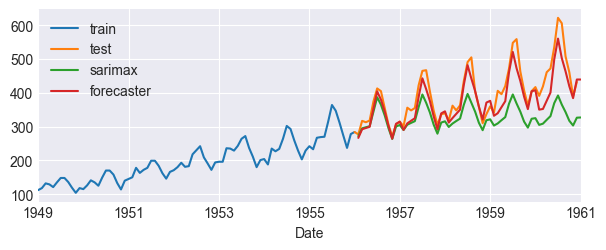

In [11]:
# Compare predictions with an arima (lags, 1, 0)
# ==============================================================================
from statsmodels.tsa.statespace.sarimax import SARIMAX
steps = len(data.loc[end_train:])

sarimax = SARIMAX(data.loc[:end_train], order=(12, 1, 0))
res_sarimax = sarimax.fit(disp=False, maxiter=1000)
predictions_sarimax = res_sarimax.get_forecast(steps).predicted_mean
display(predictions_sarimax.head(4))

forecaster = ForecasterAutoregDiff(
                 regressor       = LinearRegression(),
                 lags            = 12,
                 differentiation = 1
            )
            
forecaster.fit(y=data.loc[:end_train])
predictions = forecaster.predict(steps=steps)
display(predictions.head(4))

fig, ax = plt.subplots(figsize=(7, 2.5))
data.loc[:end_train].plot(ax=ax, label='train')
data.loc[end_train:].plot(ax=ax, label='test')
predictions_sarimax.plot(ax=ax, label='sarimax')
predictions.plot(ax=ax, label='forecaster')
ax.legend();


In [14]:
# Compare Bootstrapping predictions
# ==============================================================================
# Comparasion of results if the time series is differenciated before training or during the training
# =================================================================================================
print("Series differentiated before training")
print("-------------------------------------")
forecaster_1 = ForecasterAutoregDiff(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15
             )

forecaster_1.fit(y=data_diff.loc[:end_train])
boot_predictions_diff = forecaster_1.predict(steps=steps)
# last_value_train = data.loc[:end_train].iloc[[-1]]
# boot_predictions_1 = pd.concat([last_value_train, predictions_diff]).cumsum()[1:]
boot_predictions_1 = boot_predictions_diff
print("Predictions")
display(predictions_diff)
display(predictions_1)
print("")

print("Series differentiated during training")
print("-------------------------------------")
forecaster_2 = ForecasterAutoregDiff(
                 regressor = RandomForestRegressor(random_state=963),
                 lags      = 15,
                 differentiation = 1
               )

forecaster_2.fit(y=data.loc[:end_train])
boot_predictions_2 = forecaster_2.predict_bootstrapping(
                        steps=steps,
                        n_boot=10
)
print("Predictions")
display(boot_predictions_2)

Series differentiated before training
-------------------------------------


ValueError: The maximum lag (15) must be less than the length of the series (0).

In [13]:
forecaster = ForecasterAutoregDiff(
                regressor=RandomForestRegressor(random_state=123),
                lags=12,
                differentiation=1
            )
forecaster.fit(y=data.loc[:end_train])
boo_predictions = forecaster.predict_bootstrapping(
                        steps=len(data.loc[end_train:]),
                        n_boot=10
)
boo_predictions

UnboundLocalError: cannot access local variable 'predictions' where it is not associated with a value